In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import scipy  #mainly for the L-BFGS-B algorithm
from mpl_toolkits.mplot3d import Axes3D
import ipympl
import time
import pickle

In [3]:
N = 20

In [4]:
#Parameters
Nmax = 0.6
Nmin = 0.3
N_s = 0.01
Mmax = 6
Mmin = 1
b_max = 500
t_max = 2*60*N

# Define all subfunctions 

In [5]:
def Perturbation(X: list[float], nu: float, N:int, D:float)-> list[float]:
    '''Adds a small random perturbation to a solution, 
    X is a solution in the form (x_1, y_1, x_2, y_2, ...) 2 spherical coords for every point
    nu is a parameter from in (0,1). '''
    
    nu = nu*np.arccos((2-D**2)/2)
    for i in range(0, N, 2):
        X[i] = X[i] + np.random.uniform(-nu, nu)
        X[i+1] = X[i+1] + np.random.uniform(-nu, nu)
    
    return X

def NeighSize(beta: float, Mmax:int, Mmin:int)->float:
    '''Determines the size of the neighbourhood (i.e, the amount of points it compares before moving on the DNS() function)
    to search based on a changing parameter'''
    
    period = 2*(Mmax-Mmin)
    x = beta % period
    if x <= period/2:
        return Mmax -x
    else:
        return Mmin + (x-Mmax)+1
    
def PertStr(beta: float, Nmax:float, Nmin:float)-> float:
    '''Determines the strength of the perturbations to the solution based on a changing parameter'''
    
    period = 60
    x = beta % period
    if x<= period/2:
        return Nmin + x*(Nmax-Nmin)*2/period
    else:
        return Nmax - (x-period/2)*(Nmax-Nmin)*2/period
    
def RandSol(N: int)-> list[float]:
    ''''generates a random solution of N points. We might want to substitute this by the spiral windings or some other method'''
    return np.random.rand(2*N)

def LocalOpti(X: list[float], N:int, D: float)->list[float]:
    '''NOT OPTIMIZED YET!! - adjacency lists are not used, using BFGS instead of L-BFGS
    Multiple stage local optimization using BFGS, increasing precision as the solution gets closer to the local minimum'''
    (e_0, e_1, e_2, e_3) = (0.1*D, 0.01*D, 10**(-4)*D, 10**(-12)*D)
    (b_1, b_2, b_3) = (3*D, 2*D, 1.2*D)
    X_1 = scipy.optimize.minimize(E_D, X, method='BFGS',args=(N,D), options={'xrtol': e_0}).x
    
    X_2 = scipy.optimize.minimize(E_D, X_1, method='BFGS',args=(N,D), options={'xrtol': e_1}).x
    
    X_3 = scipy.optimize.minimize(E_D, X_2, method='BFGS',args=(N,D), options={'xrtol': e_2}).x
    
    X_4 = scipy.optimize.minimize(E_D, X_3, method='BFGS',args=(N,D), options={'xrtol': e_3}).x
    return X_4
    
    
def E_D(X0: list[float], N:int, D: float)->float:
    '''The penalty function we want to minimize. A solution with value 0 is a feasible solution of the original problem'''

    philist = X0[1::2] 
    thetalist = X0[::2]
    total = 0
    for i in range(0,N):
        for j in range(i+1, N):
            norm = 2-2*np.sin(philist[i])*np.sin(philist[j])*np.cos(thetalist[i]-thetalist[j]) -2*np.cos(philist[i])*np.cos(philist[j])
            total = total + max(0,D - np.sign(norm) * (np.abs(norm))**(1/2) )**2
    return total

def DNS(X0: list[float],N:int, D:float, Mmax:int, Mmin:int, Nmax:float, Nmin:float, b_max:int):
    ''' Dynamic Neighbourhood Search: '''
    X_curr = LocalOpti(X0,N, D)
    X_b = X_curr
    beta = 0
    
    while (beta <= b_max) and (E_D(X_b, N, D)> 10**(-25)):
        nu = PertStr(beta, Nmax, Nmin)
        M = NeighSize(beta, Mmax, Mmin)
        X_nbest = (0,0)*N
        for k in range(M):
            X_neigh = Perturbation(X_curr, nu, N, D)
            X_neigh = LocalOpti(X_neigh, N,D)
            if E_D(X_neigh,N, D)<E_D(X_nbest,N, D):
                X_nbest = X_neigh
            if E_D(X_neigh,N, D)<E_D(X_curr,N, D):
                X_nbest = X_neigh
                break
        
        X_curr = X_nbest
        if E_D(X_curr,N, D) < E_D(X_b,N, D):
            X_b = X_curr
            beta = 0
        else:
            beta += 1
    return X_b
def U_p(X0:list[float], N:int, p:int):
    X = X0[:-1]
    D = X0[-1]
    sol = -D**2 +p*E_D(X, N, D)
    return sol
def LocOpti2(sol: list[float], N:int, p:int)->list[float]:
    D = sol[-1]
    (e_0, e_1, e_2, e_3) = (0.1*D, 0.01*D, 10**(-4)*D, 10**(-12)*D)
    (b_1, b_2, b_3) = (3*D, 2*D, 1.2*D)
    sol_1 = scipy.optimize.minimize(U_p, sol, method='BFGS',args=(N,p), options={'xrtol': e_0}).x
    
    sol_2 = scipy.optimize.minimize(U_p, sol_1, method='BFGS',args=(N,p), options={'xrtol': e_1}).x
    
    sol_3 = scipy.optimize.minimize(U_p, sol_2, method='BFGS',args=(N,p), options={'xrtol': e_2}).x
    
    sol_4 = scipy.optimize.minimize(U_p, sol_3, method='BFGS',args=(N,p), options={'xrtol': e_3}).x
    return sol_4
             
def MinDistAdjustment(X0: list[float],N:int, D0:float, k:int):
    X=X0
    D=D0
    p=100
    sol = X.tolist()+[D]
    for i in range(k):
        sol = LocOpti2(sol, N, p)
        P = p*5
    return sol

# Main IDNS Algorithm

In [36]:
def General_IDNS(N: int, t_max: int)-> list[list[float], float]:
    '''Genreral procedure for the IDNS search algorithm,
    input N: number of points
    t_max: max run time before termination
    Output: The solution as a list of the form (theta_1, phi_1, theta_2, phi_2, ...) where theta and phi are angles 
    and the maximum minimum distance D'''
    
    strt = time.time()
    
    delta = 0.7
    D = 4*(delta/N)**(1/2)
    X = RandSol(N)
    X = LocalOpti(X, N, D) #First sol, likely very bad
    
    global Sequence 
    Sequence = [(N, X, D,  time.time()-strt)]
    
    while (E_D(X,N, D)>10**(-25)):  #Go back if D was too big
        
        delta += -0.01
        D = 4*(delta/N)**(1/2)
        X = DNS(X, N, D,Mmax, Mmin, Nmax, Nmin, b_max )
        print(N, 'down', E_D(X,N, D), time.time()-strt)###########################
        
    while (E_D(X,N, D)<10**(-25)) and (time.time()-strt<= t_max): #increase D slowly for precission
        delta += 0.001
        D = 4*(delta/N)**(1/2)
        X = DNS(X, N, D,Mmax, Mmin, Nmax, Nmin, b_max )
        Sequence += [(N, X, D,  time.time()-strt)]
        print(N, 'up', E_D(X,N, D), time.time()-strt)########################
    print(N, 'out')  ####################              
    sol = MinDistAdjustment(X, N, D, 15) 
    X_s = sol[:-1]
    D_s = sol[-1]
    print('mindist', E_D(X,N, D), time.time()-strt) ##########################
    Sequence += [(N, X_s, D_s,  time.time()-strt)]
                 
    while time.time()-strt <= t_max:
        D = D_s
        X = RandSol(N)
        X = DNS(X, N, D,Mmax, Mmin, Nmax, Nmin, b_max )
        if E_D(X ,N, D)<10**(-25):
            sol = MinDistAdjustment(X, N, D, 15)
            X = sol[:-1]
            D = sol[-1]
            if D > D_s:
                D_s = D
                X_s = X
                Sequence += [(N, X_s, D_s,  time.time()-strt)]
        print('end', time.time()-strt)   ##############################
        
    file = open(str(N) +' Points sequence', 'wb')
    pickle.dump(Sequence, file)
    file.close()
    print('file dumped')##################
    
    return (N, X_s, D_s)
        

# Plot the solution

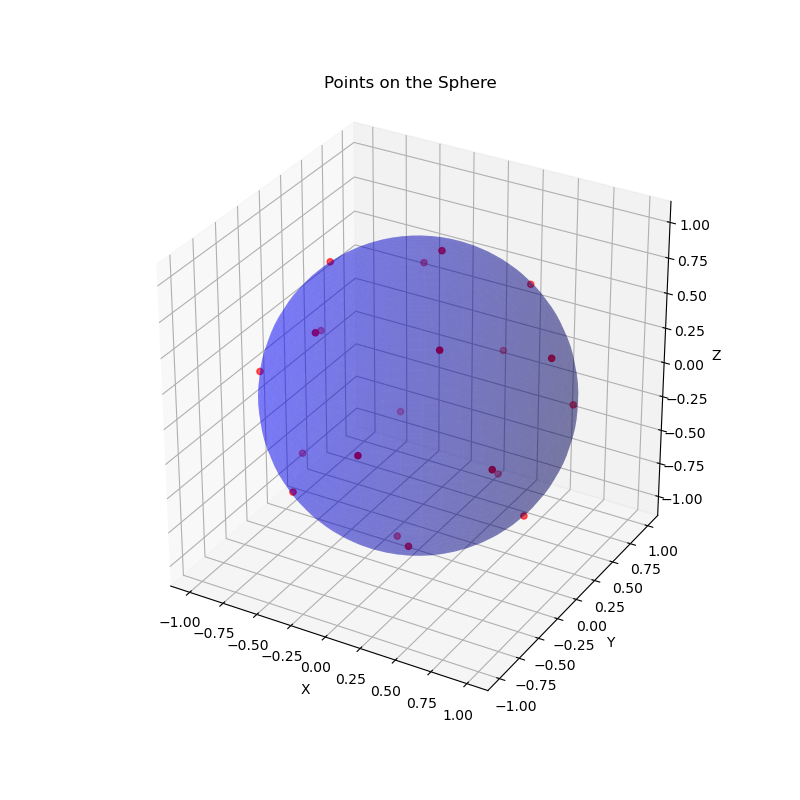

In [60]:
Xsol = Sequence[-1][0]

def plot_sphere(ax):
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
     # alpha controls opacity
    ax.plot_surface(x, y, z, color="b", alpha=0.3)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the sphere
plot_sphere(ax)

Xs = [np.sin(Xsol[i+1])*np.cos(Xsol[i]) for i in range(0,2*N, 2)]
Ys = [np.sin(Xsol[i+1])*np.sin(Xsol[i]) for i in range(0,2*N, 2)]
Zs = [np.cos(Xsol[i+1])                 for i in range(0,2*N, 2)]

ax.scatter3D(Xs, Ys, Zs, c='red', marker='o')

# Setting aspect ratio to be equal to ensure the sphere looks spherical
ax.set_box_aspect([np.ptp(axis) for axis in [ax.get_xlim(), ax.get_ylim(), ax.get_zlim()]])
ax.set_title('Points on the Sphere')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
General_IDNS(100, 2*100*60)

    